In [1]:
import configparser
import os
import pandas as pd
import math
import psycopg2
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# DB setup
DB_CONFIG = {
    "dbname": "Data_analytics",
    "user": "postgres",
    "password": "1234",
    "host": "127.0.0.1",
    "port": "5432"
}

# SQL query to retrieve all records corresponding to the year 2024
query = """
SELECT 
    client_id, gender, purchase_datetime, purchase_time_seconds, 
    product_id, quantity, price_per_item, discount_per_item, total_price
FROM sales
WHERE purchase_datetime BETWEEN '2024-01-01' AND '2024-12-31';
"""

# Load the retrieved dataset into a Pandas DataFrame for further analysis
conn = psycopg2.connect(**DB_CONFIG)
df = pd.read_sql(query, conn)
conn.close()

C:\Users\panty\AppData\Local\Temp/ipykernel_36564/2412024920.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [3]:
# Hypothesis 1

# Split the dataset into two groups based on gender: male and female customers
male_data = df[df['gender'] == 'M']
female_data = df[df['gender'] == 'F']

# Apply the Kolmogorov-Smirnov test to assess the distribution of purchase data for male customers
ks_stat_male, ks_p_value_male = stats.kstest(male_data['total_price'], 'norm', 
                                             args = (male_data['total_price'].mean(), male_data['total_price'].std()))
alpha = 0.05

if ks_p_value_male < alpha:
    male_message = "The distribution of total spendings among male customers shows a statistically significant deviation from the normal distribution"
else:
    male_message = "No evidence of non-normal distribution"

# Apply the Kolmogorov-Smirnov test to assess the distribution of purchase data for female customers
ks_stat_female, ks_p_value_female = stats.kstest(female_data['total_price'], 'norm', 
                                                 args = (female_data['total_price'].mean(), female_data['total_price'].std()))

if ks_p_value_female < alpha:
    female_message = "The distribution of total spendings among female customers shows a statistically significant deviation from the normal distribution"
else:
    female_message = "No evidence of non-normal distribution"
    
display(male_message)
display(female_message)

'The distribution of total spendings among male customers shows a statistically significant deviation from the normal distribution'

'The distribution of total spendings among female customers shows a statistically significant deviation from the normal distribution'

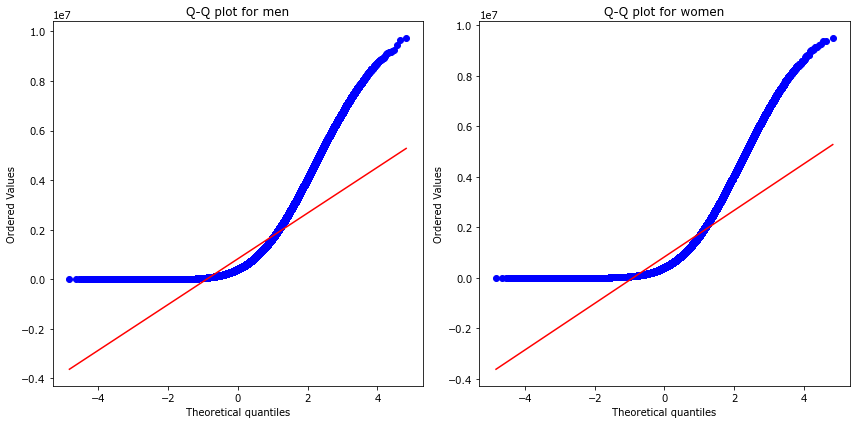

In [4]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))  # 2 plots → 1 row

# Q-Q plot for men
stats.probplot(male_data['total_price'], dist = "norm", plot = axes[0])
axes[0].set_title('Q-Q plot for men')

# Q-Q plot for women
stats.probplot(female_data['total_price'], dist = "norm", plot = axes[1])
axes[1].set_title('Q-Q plot for women')

plt.tight_layout()  
plt.show()

In [5]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(male_data['total_price'], female_data['total_price'], alternative = 'two-sided')
ms = f'U-statistics: {u_stat}, P-value: {p_value}'

if p_value < 0.05:
    st = "The statistical analysis shows a significant difference in the average order value between male and female customers"
else:
    st = "The statistical analysis shows that there is no significant difference in the average order value between male and female customers"
    
display(ms)
display(st)

'U-statistics: 499128825133.0, P-value: 0.6000521234516802'

'The statistical analysis shows that there is no significant difference in the average order value between male and female customers'

C:\Users\panty\AppData\Local\Temp/ipykernel_36564/3122374266.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x = "gender", y = "total_price", palette = ["#ffcc99", "#99ccff"])


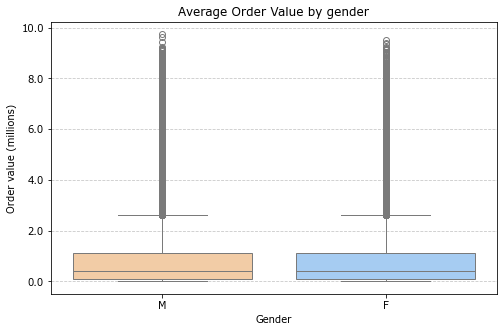

In [6]:
import matplotlib.ticker as mticker

plt.figure(figsize = (8, 5))
sns.boxplot(data = df, x = "gender", y = "total_price", palette = ["#ffcc99", "#99ccff"])
plt.title("Average Order Value by gender")
plt.xlabel("Gender")
plt.ylabel("Order value (millions)")

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-6:.1f}'))

plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show()

In [7]:
# Hypothesis 2

no_discount = df[df["discount_per_item"] == 0]
with_discount = df[df["discount_per_item"] > 0]


ks_stat_no_disc, ks_p_value_no_disc = stats.kstest(no_discount['quantity'], 'norm', 
                                                   args = (no_discount['quantity'].mean(), no_discount['quantity'].std()))
alpha = 0.05


if ks_p_value_no_disc < alpha:
    no_disc_message = "The distribution of average order size for the no-discount group shows a statistically significant deviation from the normal distribution"
else:
    no_disc_message = "No evidence of non-normal distribution"


    
ks_stat_with_disc, ks_p_value_with_disc = stats.kstest(with_discount['quantity'], 'norm', args=(with_discount['quantity'].mean(), with_discount['quantity'].std()))

if ks_p_value_with_disc < alpha:
    with_disc_message = "The distribution of average order size for the discount group shows a statistically significant deviation from the normal distribution"
else:
    with_disc_message = "No evidence of non-normal distribution"
    
    
display(no_disc_message)
display(with_disc_message)

'The distribution of average order size for the no-discount group shows a statistically significant deviation from the normal distribution'

'The distribution of average order size for the discount group shows a statistically significant deviation from the normal distribution'

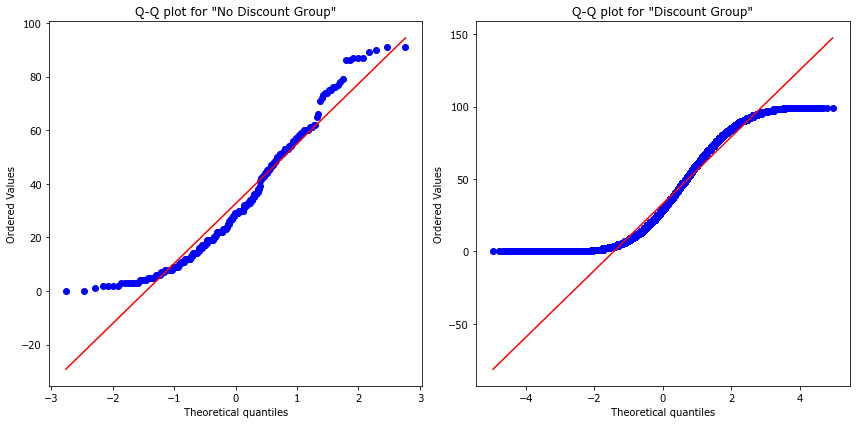

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))  

stats.probplot(no_discount['quantity'], dist = "norm", plot = axes[0])
axes[0].set_title('Q-Q plot for "No Discount Group"')

stats.probplot(with_discount['quantity'], dist = "norm", plot = axes[1])
axes[1].set_title('Q-Q plot for "Discount Group"')

plt.tight_layout()  
plt.show()

In [9]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(no_discount['quantity'], with_discount['quantity'], alternative = 'two-sided')
ms = f'U-statistics: {u_stat}, P-value: {p_value}'

if p_value < 0.05:
    st = "The statistical analysis shows a significant difference in the average number of items per order between the no-discount and discount groups"
else:
    st = "The statistical analysis shows that there is no significant difference in the average number of items per order between the no-discount and discount groups"
    
display(ms)
display(st)

'U-statistics: 242331944.5, P-value: 0.957541614339935'

'The statistical analysis shows that there is no significant difference in the average number of items per order between the no-discount and discount groups'

C:\Users\panty\AppData\Local\Temp/ipykernel_36564/4032218944.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x = df["discount_per_item"] > 0, y = "quantity", palette = ["#ff9999", "#66b3ff"])


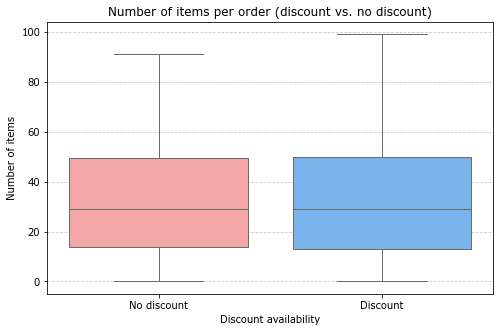

In [10]:
plt.figure(figsize=(8, 5))
sns.boxplot(data = df, x = df["discount_per_item"] > 0, y = "quantity", palette = ["#ff9999", "#66b3ff"])
plt.title("Number of items per order (discount vs. no discount)")
plt.xlabel("Discount availability")
plt.ylabel("Number of items")
plt.xticks([0, 1], ["No discount", "Discount"])
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show()

In [11]:
# Hypothesis 3

total_items_no_discount = df[df["discount_per_item"] == 0]["quantity"].sum()  # total products sold with no discount
total_items_with_discount = df[df["discount_per_item"] > 0]["quantity"].sum()  # total products sold with discount

# total number of products sold
total_items = total_items_no_discount + total_items_with_discount

# share of products sold for each group
p1 = total_items_with_discount / total_items  
p2 = total_items_no_discount / total_items  

# number of products sold in each group
counts = np.array([total_items_with_discount, total_items_no_discount])
nobs = np.array([total_items, total_items])

# Z-test
z_stat, p_value = proportions_ztest(counts, nobs, alternative='larger')

print(f"Z-statistics: {z_stat:.4f}, P-value = {p_value:.5f}")

if p_value < 0.05:
    print("H_0 rejected. Discounted items are more likely to be ordered")
else:
    print("H_0 not rejected. The difference in order frequency is not statistically significant")

Z-statistics: 11479.2903, P-value = 0.00000
H_0 rejected. Discounted items are more likely to be ordered


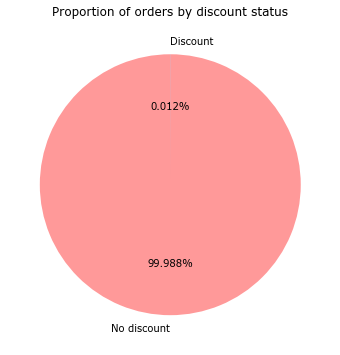

In [12]:
discount_counts = df["discount_per_item"].gt(0).value_counts()

plt.figure(figsize = (6, 6))
plt.pie(discount_counts, labels = ["No discount", "Discount"], autopct = "%1.3f%%", 
        colors = ["#ff9999", "#66b3ff"], startangle = 90)
plt.title("Proportion of orders by discount status")
plt.show()

In [13]:
# Hypothesis 4

median_price = df["price_per_item"].median()

low_price_group = df[df["price_per_item"] <= median_price]
high_price_group = df[df["price_per_item"] > median_price]


ks_stat_low_price, ks_p_value_low_price = stats.kstest(low_price_group['quantity'], 'norm', 
                                                       args = (low_price_group['quantity'].mean(), low_price_group['quantity'].std()))
alpha = 0.05


if ks_p_value_low_price < alpha:
    low_price_message = "The distribution of average sales volume for low-priced product group shows a statistically significant deviation from the normal distribution"
else:
    low_price_message = "No evidence of non-normal distribution"


ks_stat_high_price, ks_p_value_high_price = stats.kstest(high_price_group['quantity'], 'norm', 
                                                         args = (high_price_group['quantity'].mean(), high_price_group['quantity'].std()))

if ks_p_value_high_price < alpha:
    high_price_message = "The distribution of average sales volume for high-priced product group shows a statistically significant deviation from the normal distribution"
else:
    high_price_message = "No evidence of non-normal distribution"
    
    
display(low_price_message)
display(high_price_message)

'The distribution of average sales volume for low-priced product group shows a statistically significant deviation from the normal distribution'

'The distribution of average sales volume for high-priced product group shows a statistically significant deviation from the normal distribution'

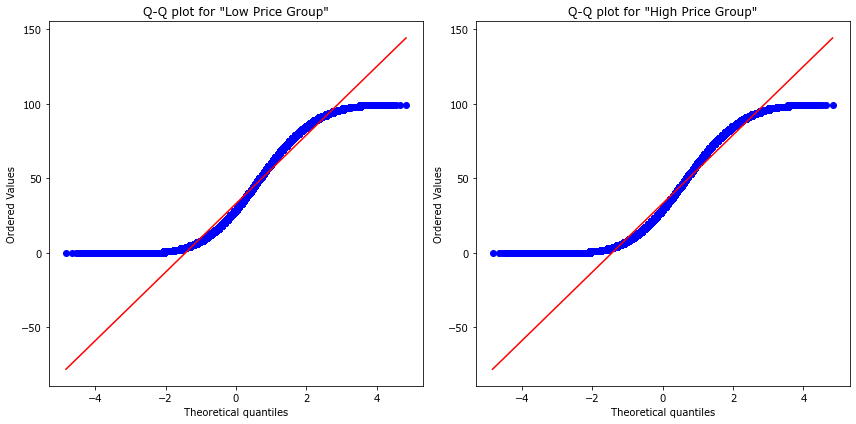

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))  

stats.probplot(low_price_group['quantity'], dist = "norm", plot = axes[0])
axes[0].set_title('Q-Q plot for "Low Price Group"')

stats.probplot(high_price_group['quantity'], dist = "norm", plot = axes[1])
axes[1].set_title('Q-Q plot for "High Price Group"')

plt.tight_layout()
plt.show()

In [15]:
u_stat, p_value = mannwhitneyu(low_price_group['quantity'], high_price_group['quantity'], alternative = 'two-sided')
ms = f'U-statistics: {u_stat}, P-value: {p_value}'

if p_value < 0.05:
    st = "The statistical analysis shows a significant difference in the average items per order between the low-priced and high-priced product groups"
else:
    st = "The statistical analysis shows that there is no significant difference in the average items per order between the low-priced and high-priced product groups"
    
display((ms))
display((st))

'U-statistics: 499289852354.0, P-value: 0.8968595614194708'

'The statistical analysis shows that there is no significant difference in the average items per order between the low-priced and high-priced product groups'

C:\Users\panty\AppData\Local\Temp/ipykernel_36564/3195241245.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x = df["price_per_item"] > df["price_per_item"].median(),


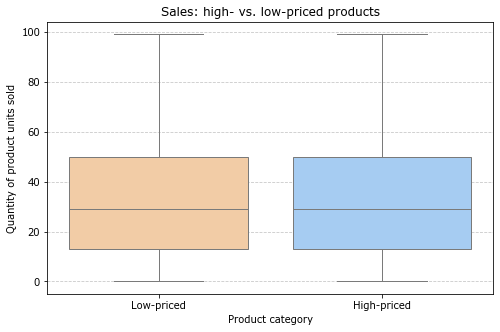

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(data = df, x = df["price_per_item"] > df["price_per_item"].median(), 
            y = "quantity", palette = ["#ffcc99", "#99ccff"])
plt.title("Sales: high- vs. low-priced products")
plt.xlabel("Product category")
plt.ylabel("Quantity of product units sold")
plt.xticks([0, 1], ["Low-priced", "High-priced"])
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show()